In [1132]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import deepxde as dde

In [1133]:
import torch

class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x-self.mean)/(self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std+self.eps
        mean = self.mean

        x = (x*std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [1134]:
coms = np.array([[-0.05117, 0.07908, 0.00086, 1],
                 [0.00269, -0.00529, 0.06845, 1],
                 [-0.07176, 0.08149, 0.00132, 1],
                 [0.00159, -0.01117, 0.02618, 1],
                 [-0.01168, 0.13111, 0.0046, 1],
                 [0.00697, 0.006, 0.06048, 1],
                 [0.005137, 0.0009572, -0.06682, 1]])
# Ixx, Iyy, Izz, Ixy, Iyz, Ixz
inertias = np.array([[0.0470910226, 0.035959884, 0.0376697645, -0.0061487003, -0.0007808689, 0.0001278755],
[0.027885975, 0.020787492, 0.0117520941,-0.0001882199, 0.0020767576, -0.00030096397],
[0.0266173355, 0.012480083, 0.0284435520,-0.0039218988, -0.001083893, 0.0002927063],
[0.0131822787, 0.009268520, 0.0071158268,-0.0001966341, 0.000745949, 0.0003603617],
[0.0166774282, 0.003746311, 0.0167545726,-0.0001865762, 0.0006473235, 0.0001840370],
[0.0070053791, 0.005527552, 0.0038760715,0.0001534806, -0.0002111503, -0.000443847],
[0.0008162135, 0.0008735012, 0.0005494148,0.000128440, 0.0001057726, 0.00018969891]])

# theta, d, a, alpha, m
dh_params = np.array([[0.2703, 0.069, -math.pi/2, 5.70044],
[0, 0, math.pi/2, 3.22698],
[0.3644, 0.069, -math.pi/2, 4.31272],
[0, 0, math.pi/2, 2.07206],
[0.3743, 0.01, -math.pi/2, 2.24665],
[0, 0, math.pi/2, 1.60979],
[0.2295,  0, 0, 0.54218]])

dof = 7
a = np.zeros(7)
d = np.zeros(7)
alpha = np.zeros(7)
m = np.zeros(7)
for i in range(7):
    a[i] = dh_params[i, 1]
    d[i] = dh_params[i, 0]
    alpha[i] = dh_params[i, 2]
    m[i] = dh_params[i, 3]

J = np.zeros((4,4,dof))
for i in range(7):
    J[:,:,i] = [[0.5*(-inertias[i,0]+inertias[i, 1]+inertias[i, 2]),inertias[i, 3],inertias[i,5], m[i]*coms[i, 0]],\
                    [inertias[i, 3], 0.5*(inertias[i,0]-inertias[i, 1]+inertias[i, 2]), inertias[i, 4], m[i]*coms[i, 1]], \
                    [inertias[i, 5], inertias[i, 4], 0.5*(inertias[i,0]+inertias[i, 1]-inertias[i, 2]), m[i]*coms[i, 2]], \
                     [m[i]*coms[i, 0], m[i]*coms[i, 1], m[i]*coms[i, 2], m[i]]]
    
Q = np.zeros((4,4))
Q[0,1] = -1
Q[1,0] = 1

In [1135]:
def compute_matrices(q, qdot):
    T01 = np.array([[math.cos(q[0]),  -math.cos(alpha[0])*math.sin(q[0]),  math.sin(alpha[0])*math.sin(q[0]), a[0]*math.cos(q[0])],
           [math.sin(q[0]),   math.cos(alpha[0])*math.cos(q[0]), -math.sin(alpha[0])*math.cos(q[0]), a[0]*math.sin(q[0])],
           [0,           math.sin(alpha[0]),            math.cos(alpha[0]),           d[0]],
           [0,           0,                        0,                       1]])   

    
    T12 = np.array([[math.cos(q[1]),  -math.cos(alpha[1])*math.sin(q[1]),  math.sin(alpha[1])*math.sin(q[1]), a[1]*math.cos(q[1])],
           [math.sin(q[1]),   math.cos(alpha[1])*math.cos(q[1]), -math.sin(alpha[1])*math.cos(q[1]), a[1]*math.sin(q[1])],
           [0,           math.sin(alpha[1]),            math.cos(alpha[1]),           d[1]],
           [0,           0,                        0,                       1]])

    T23 = np.array([[math.cos(q[2]),  -math.cos(alpha[2])*math.sin(q[2]),  math.sin(alpha[2])*math.sin(q[2]), a[2]*math.cos(q[2])],
           [math.sin(q[2]),   math.cos(alpha[2])*math.cos(q[2]), -math.sin(alpha[2])*math.cos(q[2]), a[2]*math.sin(q[2])],
           [0,           math.sin(alpha[2]),            math.cos(alpha[2]),           d[2]],
           [0,           0,                        0,                       1]])

    
    T34 = np.array([[math.cos(q[3]),  -math.cos(alpha[3])*math.sin(q[3]),  math.sin(alpha[3])*math.sin(q[3]), a[3]*math.cos(q[3])],
           [math.sin(q[3]),     math.cos(alpha[3])*math.cos(q[3]), -math.sin(alpha[3])*math.cos(q[3]), a[3]*math.sin(q[3])],
           [0,                 math.sin(alpha[3]),                 math.cos(alpha[3]),               d[3]],
           [0,           0,                        0,                       1]])

        
    T45 = np.array([[math.cos(q[4]),  -math.cos(alpha[4])*math.sin(q[4]),  math.sin(alpha[4])*math.sin(q[4]), a[4]*math.cos(q[4])],
           [math.sin(q[4]),     math.cos(alpha[4])*math.cos(q[4]), -math.sin(alpha[4])*math.cos(q[4]), a[4]*math.sin(q[4])],
           [0,                 math.sin(alpha[4]),                 math.cos(alpha[4]),               d[4]],
           [0,           0,                        0,                       1]])

        
    T56 = np.array([[math.cos(q[5]),  -math.cos(alpha[5])*math.sin(q[5]),  math.sin(alpha[5])*math.sin(q[5]), a[5]*math.cos(q[5])],
           [math.sin(q[5]),     math.cos(alpha[5])*math.cos(q[5]), -math.sin(alpha[5])*math.cos(q[5]), a[5]*math.sin(q[5])],
           [0,                 math.sin(alpha[5]),                 math.cos(alpha[5]),               d[5]],
           [0,           0,                        0,                       1]]) 

        
    T67 = np.array([[math.cos(q[6]),  -math.cos(alpha[6])*math.sin(q[6]),  math.sin(alpha[6])*math.sin(q[6]), a[6]*math.cos(q[6])],
           [math.sin(q[6]),     math.cos(alpha[6])*math.cos(q[6]), -math.sin(alpha[6])*math.cos(q[6]), a[6]*math.sin(q[6])],
           [0,                 math.sin(alpha[6]),                 math.cos(alpha[6]),               d[6]],
           [0,           0,                        0,                       1]])  

    T00 = np.identity(4);
    T11 = np.identity(4);
    T22 = np.identity(4);
    T33 = np.identity(4);
    T44 = np.identity(4);
    T55 = np.identity(4);
    T66 = np.identity(4);
    T77 = np.identity(4);
    
    T02 = (T01@T12);
    T03 = (T02@T23);
    T04 = (T03@T34);
    T05 = (T04@T45);
    T06 = (T05@T56);
    T07 = (T06@T67);
    
    T13 = (T12@T23);
    T14 = (T13@T34);
    T15 = (T14@T45);
    T16 = (T15@T56);
    T17 = (T16@T67);
    
    T24 = (T23@T34);
    T25 = (T24@T45);
    T26 = (T25@T56);
    T27 = (T26@T67);
    
    T35 = (T34@T45);
    T36 = (T35@T56);
    T37 = (T36@T67);
    
    T46 = (T45@T56);
    T47 = (T46@T67);
    
    T57 = (T56@T67);


    U = np.zeros((4,4,dof,dof));
    for i in range(1,dof+1):
        for j in range(1, dof+1):
            if j <= i:
                U[:,:,i-1,j-1] = eval('T'+str(0)+str(j-1)) @ Q @ eval('T' + str(j-1) + str(i))
            else:
                U[:,:,i-1,j-1] = np.zeros((4, 4)); 
    
    U3 = np.zeros((4,4,dof, dof, dof));
    for i in range(1, dof+1):
        for j in range(1, dof+1):
            for k in range(1, dof+1):
                if (i >= k) and (k >= j):
                    U3[:,:,i-1,j-1,k-1] = eval('T'+str(0)+str(j-1)) @ Q @ eval('T'+str(j-1)+str(k-1)) @ Q @ eval('T'+str(k-1)+str(i))
                elif (i >= j) and (j >= k):
                    U3[:,:,i-1,j-1,k-1] = eval('T'+str(0)+str(k-1)) @ Q @ eval('T'+str(k-1)+str(j-1)) @ Q @ eval('T'+str(j-1)+str(i))
                else:
                    U3[:,:,i-1,j-1,k-1] = np.zeros((4, 4))

    
    # Inertia
    D = np.zeros((dof, dof))
    for i in range(0, dof):
        for k in range(0, dof):
            res = 0;
            for j in range(max(i,k), dof):
                res = res + np.trace(U[:,:,j,k]@J[:,:,j]@(U[:,:,j,i].T))
            D[i,k] = res;

    # Coriolis
    h3 = np.zeros((dof, dof, dof))
    for i in range(0, dof):
        for k in range(0, dof):
            for m_idx in range(0, dof):
                res = 0;
                for j in range(max([i, k, m_idx]), dof):
                    res = res + np.trace(U3[:,:,j,k,m_idx] @ J[:,:,j] @ (U[:,:,j,i].T))
                h3[i,k,m_idx] = res;
    h = np.zeros(dof);
    for i in range(dof):
        sum_k = 0
        for k in range(dof):
            sum_m = 0
            for m_idx in range(dof):
                sum_m = sum_m + h3[i,k,m_idx] * qdot[k] * qdot[m_idx]
            sum_k = sum_k + sum_m
        h[i] = sum_k;

    # Gavity
    g = 9.81
    g_vec = np.array([0, 0, -g, 0]);
    c = np.zeros(dof);
    for i in range(dof):
        res = 0;
        for j in range(dof):
            res = res + (-m[j] * g_vec @ U[:,:,j,i] @ coms[j]);
        c[i] = res;

    return D, h, c

In [1136]:
def step_q(states, torque):
    x1 = states[:dof]
    x2 = states[dof:]
    M, C, G = compute_matrices(x1, x2)
    x1dot = x2
    x2dot = np.linalg.inv(M) @ (torque - C @ x2 - G)
    return np.array([x1dot, x2dot]).reshape(2*dof)

def get_error_states(states, qdes, qdesdot):
    x1 = states[:dof]
    x2 = states[dof:]
    e1 = qdes - x1
    e2 = (qdesdot - x2) + alpha_mat @ e1
    return np.array([e1, e2]).reshape(2*dof)

def compute_control(states, qdes, qdesdot, qdesddot):
    x1 = states[:dof]
    x2 = states[dof:]
    error_states = get_error_states(states, qdes, qdesdot)
    e1 = error_states[:dof]
    e2 = error_states[dof:]
    M, C, G = compute_matrices(x1, x2)
    h = qdesddot - alpha_mat @ alpha_mat @ e1 + np.linalg.inv(M) @ (C@qdesdot + G + C @ alpha_mat @ e1 - C @ e2)
    return saturate_torques(M @ (h + (beta_mat + alpha_mat)@ e2))

def saturate_torques(torque):
    min_torques = [-50, -50, -50, -50, -15, -15, -15]
    max_torques = [50, 50, 50, 50, 15, 15, 15]
    return np.maximum(min_torques, np.minimum(max_torques, torque))

def saturate_joints(joints):
    joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059, -2, -2, -2, -2, -4, -4, -4])
    joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059, 2, 2, 2, 2, 4, 4, 4])
    return np.maximum(joint_lim_min, np.minimum(joint_lim_max, joints))

def compute_predictors(X, controls, _model):
    res = np.copy(X)
    for i in range(len(controls)):
        res = saturate_joints(res + dt*step_q(res, controls[i]))
    return res.astype(np.float32)

def simulate_system(x0, qdes, qdesdot, qdesddot, dt, T, D, dof, predictor_func, model):
    t = np.arange(0, T, dt)
    q_vals = np.zeros((len(t), len(x0)))
    nD = int(round(D/dt))
    controls = np.zeros((len(t)+nD, dof))
    predictors = np.zeros((len(t), len(x0)), dtype=np.float32)
    q_vals[0] = x0
    # Setup initial controllers. This matters - ALOT. 
    controllerStatic = compute_control(q_vals[0], q_vals[0, :dof], np.zeros(7), np.zeros(7))
    controls[0:nD, :] = controllerStatic
    for i in range(1, len(t)):
        if i % 100 == 0:
            print(i, "/", len(t))
        if i > nD:
            prediction = predictor_func(q_vals[i-1], controls[i-1:i-1+nD], model)
        else:
            prediction = q_vals[i-1]
        predictors[i] = prediction
        controls[i-1+nD] = compute_control(prediction, qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
        q_vals[i] =  saturate_joints(q_vals[i-1] + dt*step_q(q_vals[i-1], controls[i-1]))
    return q_vals, controls, predictors

In [1137]:
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])

# Generate a trajecotry:
def generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D):
    t = np.arange(0, T+D, dt)
    q = np.zeros((len(t), len(joint_lim_min)))
    qd= np.zeros((len(t), len(joint_lim_min)))
    qdd = np.zeros((len(t), len(joint_lim_min)))
    for i in range(len(t)):
        # ensures positive q so we are in the joints
        q[i] = [math.sin(t[i]*period)*scaling + scaling]*len(joint_lim_min)
        qd[i] = [math.cos(t[i]*period)*scaling*period]*len(joint_lim_min)
        qdd[i] = [-math.sin(t[i]*period)*scaling*period**2] * len(joint_lim_min)
        if (np.maximum(np.minimum(q[i], joint_lim_max), joint_lim_min) != q[i]).any():
            raise Exception("Trajecotry not feasible")
    return q, qd, qdd

T = 4
period = 1
dt = 0.1
scaling = 0.1
t = np.arange(0, T, dt)
# Handles delays up to any time essentially
D = 1
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, 0.1, dt, T, D)
nD = int(round(D/dt))

In [1138]:
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
deviation = 2
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D)

init_cond = (joint_lim_max - joint_lim_min) / 2.0
init_cond = np.array([init_cond, np.zeros(7)]).reshape(14)
statesExact, controlsExact, predictorsExact = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None)

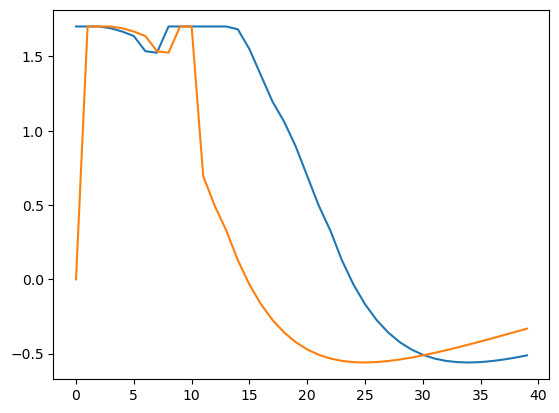

In [1139]:
plt.plot(statesExact[:, 0])
plt.plot(predictorsExact[:, 0])

In [1144]:
# Build dataset
def gen_dataset(num_data,sample_rate, dt, T, dof, D, joint_lim_min, joint_lim_max, deviation):
    t = np.arange(0, T, dt)
    qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D)
    # if(num_data % sample_rate != 0):
    #     raise Exception("Please ensure num_data % sample_rate = 0")
    # if(len(t) % sample_rate != 0):
    #     raise Exception("Please ensure int(T/dt)+1 % sample_rate = 0")
    nD = int(round(D/dt))
    inputs = np.zeros((num_data, nD+2, dof))
    outputs = np.zeros((num_data, 2*dof))
    sample_locs = np.linspace(len(t)/sample_rate-1, len(t)-1,sample_rate)
    index = 0
    num_pdes = 0
    start_time = time.time()
    print("Generating", num_data, "values with sample rate", sample_rate)
    print("This will require simulating", math.ceil(num_data/sample_rate), "PDES")
    while index+1 < num_data:
        # sample_locs = np.random.choice(np.arange(int(len(t)/sample_rate)-1, len(t)-1)[nD+1:], size=sample_rate, replace=False)
        sample_locs = np.arange(int(len(t)/sample_rate)-1, len(t)-1)[nD+1:]
        if num_pdes % 5 == 0:
            print("Simulated Trajectories: ", num_pdes, "/",  math.ceil(num_data/sample_rate))
        num_pdes += 1
        #init_cond = np.random.uniform(joint_lim_min + deviation*np.ones(len(joint_lim_min)), joint_lim_max - np.ones(len(joint_lim_max)))
        init_cond = (joint_lim_max - joint_lim_min) / 2.0 + np.random.uniform(-0.1, 0.1, dof)
        init_cond = np.array([init_cond, np.zeros(7)]).reshape(14)
        states, controls, predictors = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None)
        for i in range(len(sample_locs)):
            val = sample_locs[i]
            inputs[index, 0, 0:dof] =  states[val-1, :dof]
            inputs[index, 1, 0:dof] = states[val-1, dof:]
            inputs[index, 2:, :] = controls[val-1:val-1+nD]
            outputs[index] = predictors[val]
            index += 1
            if index+1 >= num_data:
                break
    end_time = time.time()
    inputs = inputs.reshape((num_data, (nD+2)*dof))
    outputs = outputs.reshape((num_data, 2*dof))
    np.save("inputs.npy", inputs)
    np.save("outputs.npy", outputs)
    print("Generated successfully. Total time:", end_time-start_time)


In [ ]:
alpha_mat = np.identity(dof)
beta_mat = np.identity(dof)
gen_dataset(290, 29, dt, T, dof, D, joint_lim_min, joint_lim_max, 2)

Generating 290 values with sample rate 29
This will require simulating 10 PDES
Simulated Trajectories:  0 / 10
Simulated Trajectories:  5 / 10


In [ ]:
# Loading float32 does introduce some small numerical error, but not large. 
inputs = np.load("inputs.npy").astype(np.float32)
outputs = np.load("outputs.npy").astype(np.float32)

In [ ]:
# Parametersdetach
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1, shuffle=True)
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
#XNormalizer = UnitGaussianNormalizer(x_train)
#x_train = XNormalizer.encode(x_train)
#x_test = XNormalizer.encode(x_test)

y_train = torch.from_numpy(y_train).cuda()
y_test = torch.from_numpy(y_test).cuda()
#YNormalizer = UnitGaussianNormalizer(y_train)
#y_train = YNormalizer.encode(y_train)
# y_test = YNormalizer.encode(y_test)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [ ]:
class DeepONetProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2):
        super().__init__()
        self.deeponet = dde.nn.DeepONetCartesianProd([m, 128, 128, 128], [dim_x, 128, 128, 128], "relu", "Glorot normal").cuda()
        self.linear1 = torch.nn.Linear(m, proj1)
        self.linear2 = torch.nn.Linear(proj1, proj2)

    def forward(self, x):
        y = self.deeponet(x)
        y = self.linear1(y)
        return self.linear2(y)

In [ ]:
spatial = np.arange(0, D+2*dt, dt/(dof)).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
print(grid.shape)

In [ ]:
def train_model(model, num_epochs, model_type):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss = torch.nn.MSELoss()
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
            optimizer.zero_grad()
            if model_type == "DeepONet":
                out = model((x_vals, grid))
            else:
                out = model(x_vals)
    
            lp = loss(out, y_vals)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
                if model_type == "DeepONet":
                    out = model((x_vals, grid))
                else:
                    out = model(x_vals)
                test_loss += loss(out, y_vals).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%50 == 0:
            print(ep, t2-t1, train_loss, test_loss)
    return model, train_lossArr, test_lossArr

def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])

In [ ]:
modelDeepONet = DeepONetProjected(grid.shape[0], 1, 48, 2*dof).cuda()

In [ ]:
modelDeepONet, train_lossArrDeepONet, test_lossArrDeepONet = train_model(modelDeepONet, 500, "DeepONet")

In [ ]:
evaluate_model(modelDeepONet, "DeepONet", train_lossArrDeepONet, test_lossArrDeepONet)

In [ ]:
for x_vals, y_vals in trainData:
    x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
    break
out = modelDeepONet((x_vals, grid))
index = 1
x_vals = x_vals[index].reshape(12, 7)
states = np.array([x_vals[0].detach().cpu().numpy(), x_vals[1].detach().cpu().numpy()]).reshape(14)
controls = x_vals[2:].detach().cpu().numpy()
print("states", states)
print("controls", controls)
print(compute_predictors(states, controls, None))
print(y_vals[index])
print(out[index])
print(torch.norm(y_vals[index]-out[index]))
#print(controlsExact[0:nD])
#print(x_vals[0, 14:])

In [1118]:
def ml_predictor_deeponet(state, controls, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back.
    inputs = np.zeros((controls.shape[0]+2, controls.shape[1]))
    inputs[0] = state[:dof]
    inputs[1] = state[dof:]
    inputs[2:, :] = controls
    inputs = inputs.reshape((1, (controls.shape[0]+2) * controls.shape[1])).astype(np.float32)
    inputs = torch.from_numpy(inputs).cuda()
    output = model((inputs, grid)).detach().cpu().numpy().reshape(2*dof)
    print("states", states)
    print("controls", controls)
    print("estimate", output)
    print("true", compute_predictors(state, controls, None))
    x_vals = inputs[0].reshape(12, 7)
    newStates = np.array([x_vals[0].detach().cpu().numpy(), x_vals[1].detach().cpu().numpy()]).reshape(14)
    newControls = x_vals[2:].detach().cpu().numpy()
    print("estimateOut", compute_predictors(newStates, newControls, None))
    print("diff", np.linalg.norm(output- compute_predictors(state, controls, None)))
    # output = YNormalizer.decode(output).detach().cpu().numpy().reshape(2*dof)
    return output

In [1119]:
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
deviation = 2
T = 4
t = np.arange(0, T, dt)
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D)

init_cond = (joint_lim_max - joint_lim_min) / 2.0
init_cond = np.array([init_cond, np.zeros(7)]).reshape(14)
statesExact, controlsExact, predictorsExact = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None)

In [1120]:
T = 4
t = np.arange(0, T, dt)
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D)
statesDeepONet, controlsDeepONet, predictorsDeepONet = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, ml_predictor_deeponet, modelDeepONet)

states [ 1.7016     -0.29680103  3.0541      2.618       3.059       2.094
  3.059       2.         -2.          2.          2.          4.
  4.          4.        ]
controls [[-1.39988866e+00 -4.47247666e+01  1.79572541e+00  5.63245189e+00
  -2.28998372e-01 -1.62968281e+00  1.84465199e-03]
 [-5.60340068e-01 -2.91605272e+01  9.61122179e-01 -1.92070490e+00
  -1.42049438e-01 -1.89064962e+00 -1.63585599e-03]
 [-6.62905496e-01 -2.64064125e+01  8.30053129e-01 -3.44601108e+00
  -2.30945504e-01 -2.03816810e+00 -9.09189873e-02]
 [-9.37109989e-01 -2.18027329e+01  5.23183386e-01 -6.85953874e+00
  -5.71905797e-01 -2.44713622e+00 -3.88359704e-01]
 [ 1.26814038e+00 -1.47596433e+01  1.61003594e+00 -8.43560390e+00
   1.25851057e+00 -6.06490669e-01  1.42604742e+00]
 [-3.30466070e+00 -1.28662678e+01 -1.91733948e+00 -1.60771221e+01
  -3.35637480e+00 -4.87767000e+00 -3.24858682e+00]
 [-8.11436015e+00 -9.10133750e+00 -7.36493561e+00 -2.22724479e+01
  -5.96208993e+00 -7.78064002e+00 -6.82098329e+00]
 [-1.4

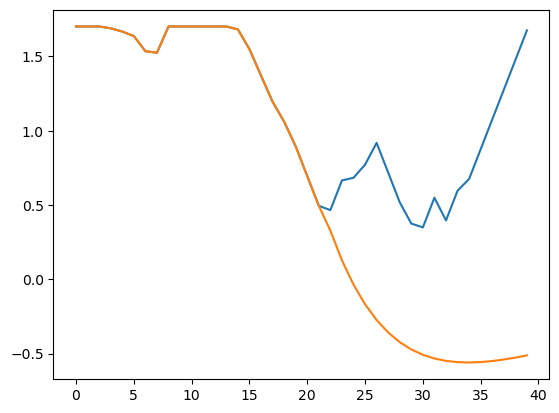

In [1080]:
plt.plot(statesDeepONet[:, 0])
plt.plot(statesExact[:, 0])

In [334]:
dt = 0.1

spatial = np.arange(0, D+2*dt, dt/(dof)).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
nD = int(round(D/dt))
modelDeepONet = DeepONetProjected(grid.shape[0], 1, 48, 2*dof).cuda()
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])

init_cond = (joint_lim_max - joint_lim_min) / 2.0
init_cond = np.array([init_cond, np.zeros(7)]).reshape(int(2*dof))
controllerStatic = compute_control(init_cond, init_cond[:dof], np.zeros(dof), np.zeros(dof))
controls  = np.tile(controllerStatic, nD)
controls = controls.reshape((nD, dof))

start = time.time()
for i in range(1):
    res1 = compute_predictors(init_cond, controls, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1):
     res2 = ml_predictor_deeponet(init_cond, controls, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
# start = time.time()
# for i in range(1000):
#     delay = np.random.uniform(0.5, 1.7)
#     ml_predictor_fno(state, x, delay, x, modelFNO)
# end = time.time()
# ml_time_fno = end-start
# print("ML time FNO", ml_time_fno)
# print("Speedup FNO", numerical_time/ml_time_fno)

Numerical time 0.08923482894897461
ML time DeepONet 0.0010101795196533203
Speedup DeepONet 88.33561482180788
[ 1.7016     -0.09680104  3.0541      2.618       3.059       2.094
  3.059       2.         -2.          2.          2.          4.
  4.          4.        ]
[ 0.12034355  0.15900195  0.16582195  0.02872089 -0.11927064 -0.14420223
  0.26611748  0.05298803 -0.17959836  0.10778254  0.21658355  0.0886845
 -0.40950945 -0.1255613 ]
